In [64]:
import numpy as np

from skimage import (
    restoration
)

import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage
plt.rcParams["figure.dpi"] = 300

In [55]:
def rolling_ball_denoise(img, radius):
    # kernel = restoration.ellipsoid_kernel(
    #     (radius * 2, radius * 2),
    #     radius * 2
    # )
    kernel = restoration.ball_kernel(
        radius,
        2
    )
    background = restoration.rolling_ball(img, kernel=kernel)
    image_sub = img - background
    return image_sub


def save_np_img(npimg, path):
    """Sava a numpy array as an image.

    Args:
        npimg (numpy array): A numpy array need to be saved as image.
        path (string): The save path.
    """
    img = Image.fromarray(npimg)
    img = img.convert("L")
    img.save(path, dpi=(300.0, 300.0))


def cal_integral(x, y, img, inte_map):
    if x == 0 and y == 0:
        integral = img[x, y]
    elif x == 0 and y != 0:
        integral = img[x, y] + inte_map[x, y - 1]
    elif y == 0 and x != 0:
        integral = img[x, y] + inte_map[x - 1, y]
    else:
        integral = img[x, y] + inte_map[x - 1, y] + inte_map[x, y - 1] - inte_map[x - 1, y - 1]
    return integral


def integral_map(img):
    h, w = np.shape(img)
    inte_map = np.zeros((h, w))
    inte_map[0, 0] = img[0, 0]
    for i in range(0, h):
        for j in range(0, w):
            inte_map[i, j] = cal_integral(i, j, img, inte_map)
    return inte_map


def bradley_adaptive_local_thresholding(img, s, t):
    """
    This function uses Bradley's adaptive local thresholding methods to do the image segmentation.
    :param img:
    :param s:
    :param t:
    :return:
    """
    h, w = np.shape(img)
    inte_map = integral_map(img)
    out_img = np.zeros((h, w))
    for i in range(0, h):
        for j in range(0, w):
            x1 = int(max(i - s / 2 + 1, 1))
            x2 = int(min(i + s / 2, h - 1))
            y1 = int(max(j - s / 2 + 1, 1))
            y2 = int(min(j + s / 2, w - 1))
            count = (x2 - x1) * (y2 - y1)
            sum_intensity = inte_map[x2, y2] - inte_map[x2, y1 - 1] - inte_map[x1 - 1, y2] + inte_map[x1 - 1, y1 - 1]
            if img[i, j] * count <= (sum_intensity * (100 - t) / 100):
                out_img[i, j] = 0
            else:
                out_img[i, j] = img[i, j]
    return out_img

def show_blob_detection_res(img_path, min_sigma, max_sigma, threshold, method=0):
    """
    Showing the result of 'blob detection' function. Used as the same way of 'blob_detection'
    """
    fig, ax = plt.subplots()
    img = io.imread(img_path)
    ax.imshow(img)
    if method == 0:
        res = blob_dog(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    else:
        res = blob_doh(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    i = 0
    CM = []
    r = 3
    [h, w] = img.shape
    for blob in res:
        y, x, r = blob
        # print(r)
        if y > r and y < (h - r) and x > r and x < (w - r):
            CM.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
                )
            )
            CM[i] = list(np.add(CM[i], [y - r, x - r]))
            x1, y1 = CM[i]
            c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            i += 1
    ax.set_axis_off()
    plt.show()

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


[[  147   188   167 ...     3     9     0]
 [   70    62    79 ...    11     0    15]
 [    0     0     0 ...     7     0    15]
 ...
 [    0     0    35 ...  1693  1858   672]
 [   64   143   215 ...  7205  6784  4695]
 [ 1579  1633  1672 ... 16591 16455 14013]]
[[5.34887609e-01 9.41701095e-01 7.11597763e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.46912664e-01 3.76228602e-01 5.26432233e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 1.37669894e-01 ... 1.47869417e+01
  1.62448004e+01 5.76588830e+00]
 [3.93899617e-01 1.09190473e+00 1.54538547e+00 ... 6.28959009e+01
  5.91761522e+01 4.07187766e+01]
 [1.32142213e+01 1.36644520e+01 1.37729689e+01 ... 1.43589908e+02
  1.42388279e+02 1.20811969e+02]]


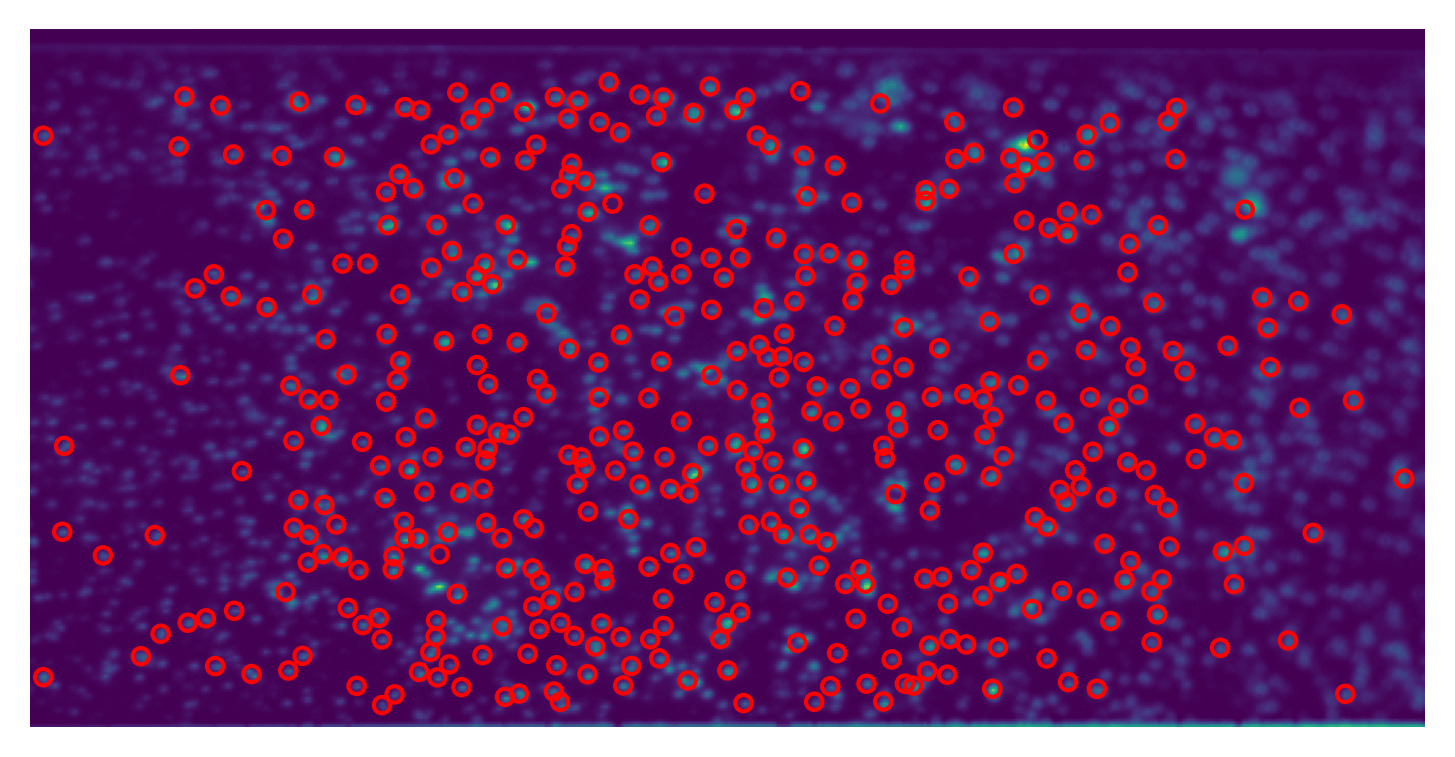

In [67]:
image = io.imread(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/ThesisImages/cy3channel.tif"
)
print(image)
image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 256
subtracted_img = rolling_ball_denoise(image, 3)
print(subtracted_img)
save_np_img(
    subtracted_img,
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/ThesisImages/subtracted_img.png",
)
out_img = bradley_adaptive_local_thresholding(subtracted_img, 10, 20)
save_np_img(
    image, "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/ThesisImages/bradly_img_cy3.png"
)
show_blob_detection_res(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/ThesisImages/bradly_img_cy3.png",
    3,
    50,
    0.001,
    method=1
)
